# Tutorial on how to work on the dataset

In [1]:
# Uncomment to install dependecies to run on Colab:
#!sudo apt-get install fluidsynth
#!pip install pretty_midi mir_eval pyfluidsynth

# For Python2.6 compatibility
from __future__ import print_function

import pretty_midi
import numpy as np
import scipy.sparse as sparse
import torch
import random
from pathlib import Path
# For plotting
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython
import sys
import os
# Parallel processing
from tqdm.contrib.concurrent import process_map

# Import project modules
REPO_ROOT = Path('.').resolve().parent
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from src.data.dataset import PianoDataset, midi_to_matrix
from src.utils.visualization import display_chromagram

### Utility function to plot a MIDI file

In [2]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

Tracce da analizzare:

- ../data/clean_midi/883/Hanno ucciso l'uomo ragno.mid
- ../data/clean_midi/883/Grazie mille.mid (**white noise?!** La causa sebra essere la velocity (forza) delle note, ma si può modificare manualmente)
- ../data/clean_midi/Vasco/Albachiara.mid (Grande spazio senza piano, dovremmo rimuoverlo?)
- ../data/clean_midi/Zappa/Peaches en Regalia.mid (tutti program number 0 ma che rappresentano strumenti differenti)

C:\Users\Andrea\AppData\Local\Temp\ipykernel_5172\3913294799.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


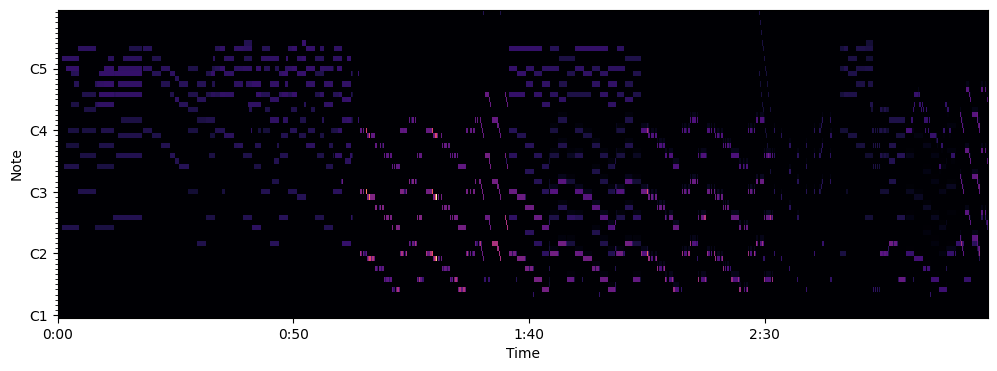

In [3]:
# We'll load in the example.mid file distributed with pretty_midi
pm = pretty_midi.PrettyMIDI("../data/clean_midi/Vasco/Albachiara.mid")


plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

### Instrument composition

Ogni strumento è associato a un program number. I program numbers [0, 1, 2, 3, 4, 5, 6, 7] sono quelli associati al pianoforte. Tuttavia, a volte lo stesso program number può corrispondere a una traccia di batteria, nel qual caso il flag `instr.is_drum` è True.

In [4]:
widths = [14, 25, 27]
print(f'{"Program number":<{widths[0]}} | {"Instrument":<{widths[1]}} | {"Class":<{widths[2]}}')
print('-' * sum(widths))

for i in range(128):
    instrument_name = pretty_midi.program_to_instrument_name(i)
    instrument_class = pretty_midi.program_to_instrument_class(i)
    print(f'{i:<{widths[0]}} | {instrument_name:<{widths[1]}} | {instrument_class:<{widths[2]}}')

Program number | Instrument                | Class                      
------------------------------------------------------------------
0              | Acoustic Grand Piano      | Piano                      
1              | Bright Acoustic Piano     | Piano                      
2              | Electric Grand Piano      | Piano                      
3              | Honky-tonk Piano          | Piano                      
4              | Electric Piano 1          | Piano                      
5              | Electric Piano 2          | Piano                      
6              | Harpsichord               | Piano                      
7              | Clavinet                  | Piano                      
8              | Celesta                   | Chromatic Percussion       
9              | Glockenspiel              | Chromatic Percussion       
10             | Music Box                 | Chromatic Percussion       
11             | Vibraphone                | Chromatic Pe

In [5]:
# print information about each instrument in the MIDI file
for instr in pm.instruments: 
    print(instr)

Instrument(program=33, is_drum=False, name="FINGERDBAS")
Instrument(program=25, is_drum=False, name="STEEL GTR")
Instrument(program=28, is_drum=False, name="MUTED GTR")
Instrument(program=0, is_drum=False, name="PRG.CHANGE")
Instrument(program=88, is_drum=False, name="PRG.CHANGE")
Instrument(program=17, is_drum=False, name="PRG.CHANGE")
Instrument(program=28, is_drum=False, name="PRG.CHANGE")
Instrument(program=127, is_drum=True, name="DRUMS")


### Extract only piano track

In [6]:
piano_instruments = [instr for instr in pm.instruments 
                        if instr.program in [0, 1, 2, 3, 4, 5, 6, 7] and not instr.is_drum]

# Print selectded piano instruments
for instr in piano_instruments:
    print(instr)

Instrument(program=0, is_drum=False, name="PRG.CHANGE")


[Instrument(program=0, is_drum=False, name="PRG.CHANGE")]


C:\Users\Andrea\AppData\Local\Temp\ipykernel_5172\3913294799.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


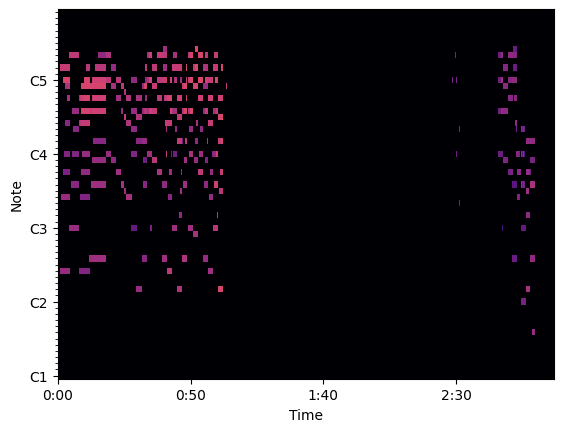

In [7]:
pm_piano = pretty_midi.PrettyMIDI()
for piano_instr in piano_instruments:
    pm_piano.instruments.append(piano_instr)

print(pm_piano.instruments)

if len(pm_piano.instruments) != 0:
    plot_piano_roll(pm_piano, 24, 84)
    audio = IPython.display.Audio(pm_piano.fluidsynth(fs=16000), rate=16000)
    IPython.display.display(audio)
else:
    print("No piano instruments found in this MIDI file.")

# save the piano-only MIDI to a new file
pm_piano.write("out.mid")

### Extract piano roll in matrix form

Ci sono due modi possibili per esportare un MIDI come una matrice o un tensor:

#### 1. Piano Roll

- 128 righe che corrispondono alle note MIDI totali e colonne che rappresentano intervalli temporali.
- Ogni riga corrisponde a una nota MIDI specifica (tutti i 12 semitoni su più ottave).
- Il valore in ogni cella indica velocità (velocity) della nota.
- Permette la ricostruzione precisa e dettagliata della melodia, durata e dinamica delle note.

In [8]:
fs = 100  # sampling rate per second

piano_roll = pm_piano.get_piano_roll(fs)

print("Piano-roll shape:", piano_roll.shape)
n_pitches, n_frames = piano_roll.shape
duration_seconds = n_frames / fs
print(f"Duration (s): {duration_seconds:.2f}, frames: {n_frames}, fs: {fs}")

np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize )
print(piano_roll[:, fs*50:51*fs])
np.set_printoptions()

Piano-roll shape: (128, 18688)
Duration (s): 186.88, frames: 18688, fs: 100
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

#### 2. Chromagram

- Rappresentazione dell'intensità delle 12 classi di note (semitoni) nel tempo, basata sull'analisi audio.
- Mostra quali note sono presenti e con quale energia, indipendentemente dall'ottava.
- Utile per analisi armonica, riconoscimento accordi e pattern, ma ricostruzione della melodia meno precisa.

In [9]:
chromagram = pm_piano.get_chroma(fs=100)

print("Chromagram shape:", chromagram.shape)
n_pitches, n_frames = chromagram.shape
duration_seconds = n_frames / fs
print(f"Duration (s): {duration_seconds:.2f}, frames: {n_frames}, fs: {fs}")

np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize )
print(chromagram[:, fs*50:51*fs])
np.set_printoptions()

Chromagram shape: (12, 18688)
Duration (s): 186.88, frames: 18688, fs: 100
[[321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321. 321.  87.  87.  87.  87.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 

### Process the whole dataset with parallel execution

In [10]:
clean_midi_path = REPO_ROOT / 'data' / 'clean_midi'
save_path = REPO_ROOT / 'data' / 'processed_midi_matrices'
save_path.mkdir(parents=True, exist_ok=True)

# Solves problem "Adventures of Stevie V." (path with final dot)
if os.name == 'nt':
        clean_midi_path = Path(f"\\\\?\\{str(clean_midi_path.resolve())}")

# Get list of all MIDI files
midi_files = list(clean_midi_path.rglob('*.mid'))

# Parallel processing of MIDI files
if __name__ == '__main__':
    results = process_map(
        midi_to_matrix, 
        midi_files, 
        max_workers=os.cpu_count(), 
        chunksize=10,
        desc="Processing MIDI Parallel"
    )

Processing MIDI Parallel:   0%|          | 0/17256 [00:00<?, ?it/s]

### Visualize one file randomly

Caricamento file: Kashmir.1_sparse.npz


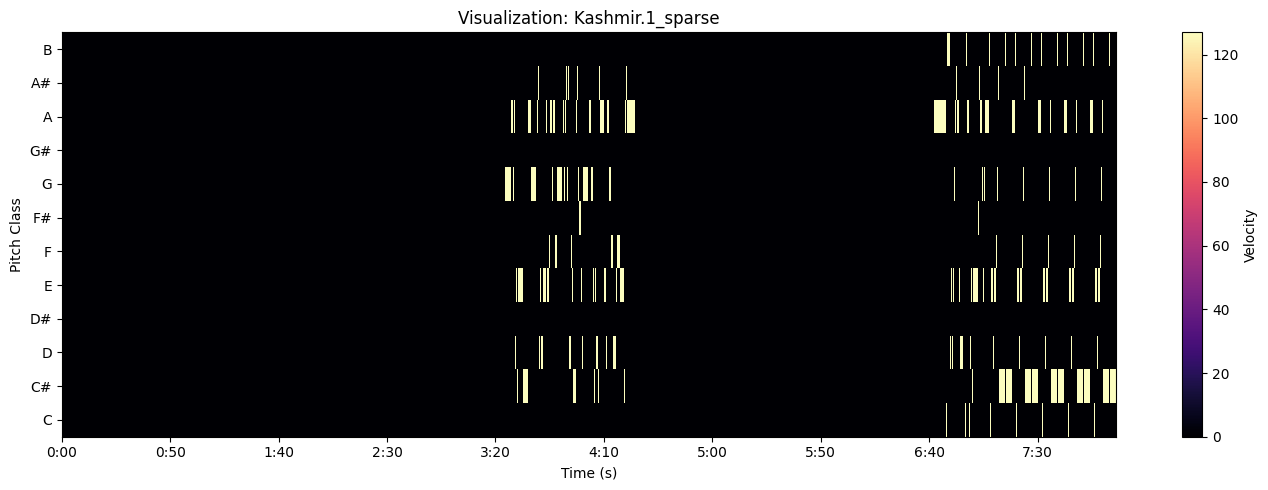

In [11]:
save_path = (REPO_ROOT / 'data' / 'processed_midi_matrices').resolve()

npz_files = list(save_path.glob('*.npz'))

if not npz_files:
    print("Nessun file trovato! Controlla il percorso.")
else:
    random_file = random.choice(npz_files)
    print(f"Caricamento file: {random_file.name}")

    sparse_matrix = sparse.load_npz(random_file)
    
    dense_matrix = sparse_matrix.toarray()

    display_chromagram(dense_matrix, title=f"Visualization: {random_file.stem}")


### Load the datasets

In [ ]:
train_size = int(0.8 * len(npz_files))
val_size = len(npz_files) - train_size
train_paths, val_paths = torch.utils.data.random_split(npz_files, [train_size, val_size])

train_dataset = PianoDataset(train_paths)
val_dataset = PianoDataset(val_paths)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)